In [2]:
# Import dependencies
import pandas as pd
import scipy.stats as st
from scipy import optimize
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Prepare the dataset for analysis
# Read in csv file
file_path = "Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv"
inital_df = pd.read_csv(file_path)

# Drop the unwanted columns.
inital_df = inital_df.drop(columns=['Data As Of', 'Start Date', 'End Date', 'ICD10_codes', 'Number of Mentions', 'Flag'])

# Only keep the rows where the Group is "By Month", and delete the row where Age Group is "All Ages"
inital_df = inital_df.loc[inital_df['Group'] == 'By Month']
clean_df = inital_df.loc[inital_df['Age Group'] != 'All Ages']

# Drop the NaN values
clean_df = clean_df.dropna()

# Convert Year and Month columns to integers
clean_df.loc[:, 'Year'] = clean_df['Year'].astype(int)
clean_df.loc[:, 'Month'] = clean_df['Month'].astype(int)
clean_df.loc[:, 'COVID-19 Deaths'] = clean_df['COVID-19 Deaths'].astype(int)

clean_df.head()

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
62100,By Month,2020,1,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62101,By Month,2020,2,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62102,By Month,2020,3,United States,Respiratory diseases,Influenza and pneumonia,0-24,9
62103,By Month,2020,4,United States,Respiratory diseases,Influenza and pneumonia,0-24,27
62104,By Month,2020,5,United States,Respiratory diseases,Influenza and pneumonia,0-24,19


In [117]:
# Group Covid-19 deaths by year and month while keeping months in order
grouped_df = clean_df.groupby(['Year', 'Month'])['COVID-19 Deaths'].sum().reset_index()
grouped_df.sort_values(by=['Year', 'Month'])


# Group into seasons by defining a function to return the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"
# Apply the function to the dataframe and create a new column named "Season"    
grouped_df['Season'] = grouped_df['Month'].apply(get_season)

# Group the dataframe by year and season and sum the covid-19 deaths
covid_seasons = grouped_df.groupby(['Year', 'Season'])['COVID-19 Deaths'].sum().reset_index()

# Sort the dataframe by year and season for looping purposes
covid_seasons = covid_seasons.sort_values(by=['Year','Season'], ascending= False)


In [118]:
# Create a function to rename the seasons to include the year for plotting legend
def rename_seasons(season):
       season += [''] * (4 - len(season))
       return [f'{s} {year}' for s in season]

# Create a dictionary to store the seasons and years       
covid_years = covid_seasons['Year'].unique()
season_year = {}

# Loop through the years and seasons to rename the seasons
for year in covid_years:
    seasons = covid_seasons.loc[covid_seasons['Year'] == year, 'Season'].tolist()
    season_year[year] = rename_seasons(seasons)

# Loop through the years and seasons to rename the seasons in the dataframe
for year in covid_years:
    for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall']):
        covid_seasons.loc[(covid_seasons['Year'] == year) & (covid_seasons['Season'] == season), 'Season'] = season_year[year][i]
        covid_seasons.pivot(index='Year', columns='Season', values='COVID-19 Deaths')


# Sort the dataframe by year and season for plotting purposes
covid_seasons = covid_seasons.sort_values(by=['Year','Season'], ascending= True)
covid_seasons.head()


,Year,Season,COVID-19 Deaths
0,2020,Fall 2020,705529
2,2020,Spring 2020,571228
1,2020,Summer 2020,751464
3,2020,Winter 2020,731229
4,2021,Fall 2021,1029730


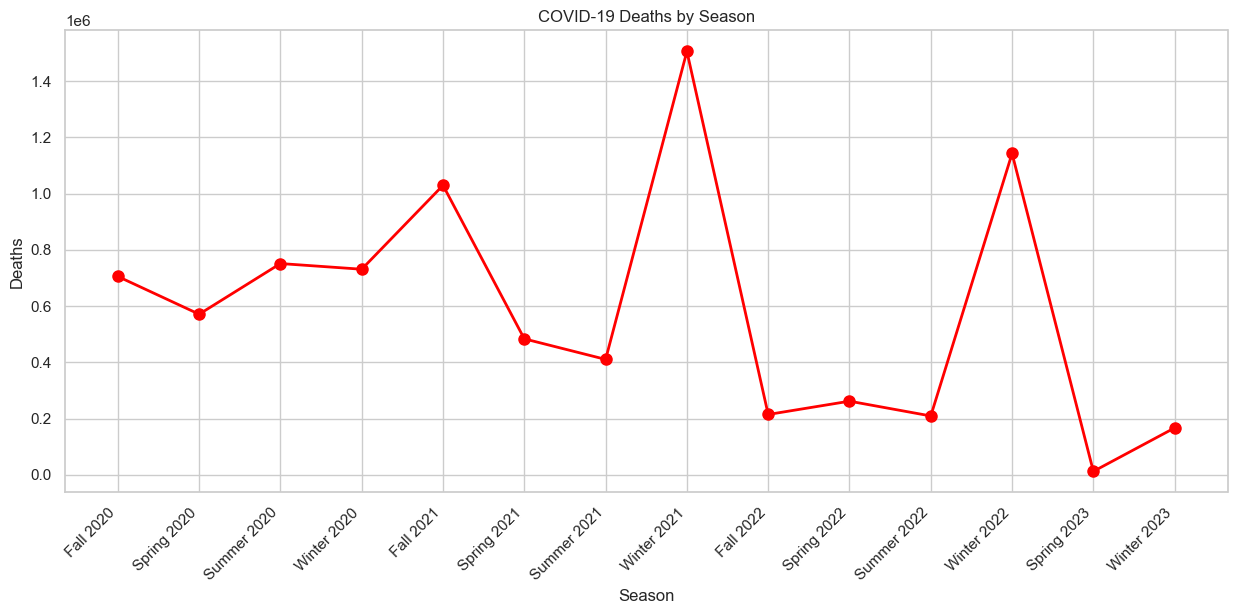

In [128]:
# Create a Line Graph to show the number of COVID-19 deaths by season
# Plot the data
plt.figure(figsize=(15, 6))          
plt.plot(covid_seasons['Season'], covid_seasons['COVID-19 Deaths'], color='red', marker='o', linewidth=2, markersize=8)
plt.gca().set_xticks(covid_seasons['Season'])
plt.gca().set_xticklabels(covid_seasons['Season'], rotation=45, ha='right')
plt.title('COVID-19 Deaths by Season')
plt.xlabel('Season')
plt.ylabel('Deaths')

# Show the plot
plt.show()

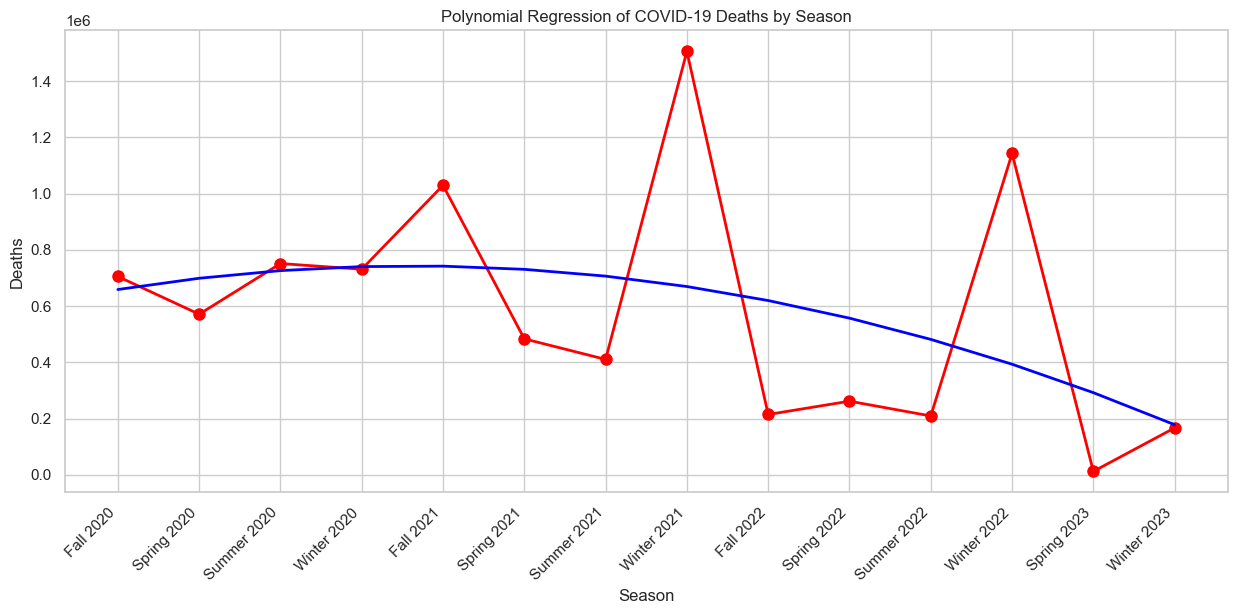

In [101]:
# Polynomial Regression
# Create a dictionary to map the seasons to integers
season_dict = {'Fall 2020': 1,
               'Spring 2020': 2,
               'Summer 2020': 3,
               'Winter 2020': 4,
               'Fall 2021': 5,
               'Spring 2021': 6,
               'Summer 2021': 7,
               'Winter 2021': 8,
               'Fall 2022': 9,
               'Spring 2022': 10,
               'Summer 2022': 11,
               'Winter 2022': 12,
               'Spring 2023': 13,
               'Winter 2023': 14,}

# Create a list of the seasons and a list of the deaths
season = covid_seasons['Season']
deaths = covid_seasons['COVID-19 Deaths']

# Convert the seasons to integers
season_integer = [season_dict[s] for s in season]

# Create the polynomial regression model
poly = PolynomialFeatures(degree=2)
season_poly = poly.fit_transform(np.array(season_integer).reshape(-1, 1))
model = LinearRegression()
model.fit(season_poly, deaths)

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(covid_seasons['Season'], deaths, color='red', marker='o',linewidth=2, markersize=8)
plt.plot(covid_seasons['Season'], model.predict(season_poly), color='blue', linewidth=2)
plt.gca().set_xticks(covid_seasons['Season'])
plt.gca().set_xticklabels(covid_seasons['Season'], rotation=45, ha='right')
plt.title('Polynomial Regression of COVID-19 Deaths by Season')
plt.xlabel('Season')
plt.ylabel('Deaths')

# Show the plot
plt.show()

In [113]:
# Group Covid-19 deaths by year and month while keeping months in order
grouped_df = clean_df.groupby(['Year', 'Month', 'Condition Group', 'Condition'])['COVID-19 Deaths'].sum().reset_index()
grouped_df.sort_values(by=['Year', 'Month'])


# Group into seasons by defining a function to return the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
# Apply the function to the dataframe and create a new column named "Season"    
grouped_df['Season'] = grouped_df['Month'].apply(get_season)

# Only keep the rows where the COVID-19 Deaths is not 0
grouped_df = grouped_df[grouped_df['COVID-19 Deaths'] != 0]

# Group the data by year, season, and condition
condition_df = grouped_df.groupby(['Year', 'Season', 'Condition'])['COVID-19 Deaths'].sum().reset_index()

# Group the data by year, season, and condition group
condition_group_df = grouped_df.groupby(['Year', 'Season', 'Condition Group'])['COVID-19 Deaths'].sum().reset_index()


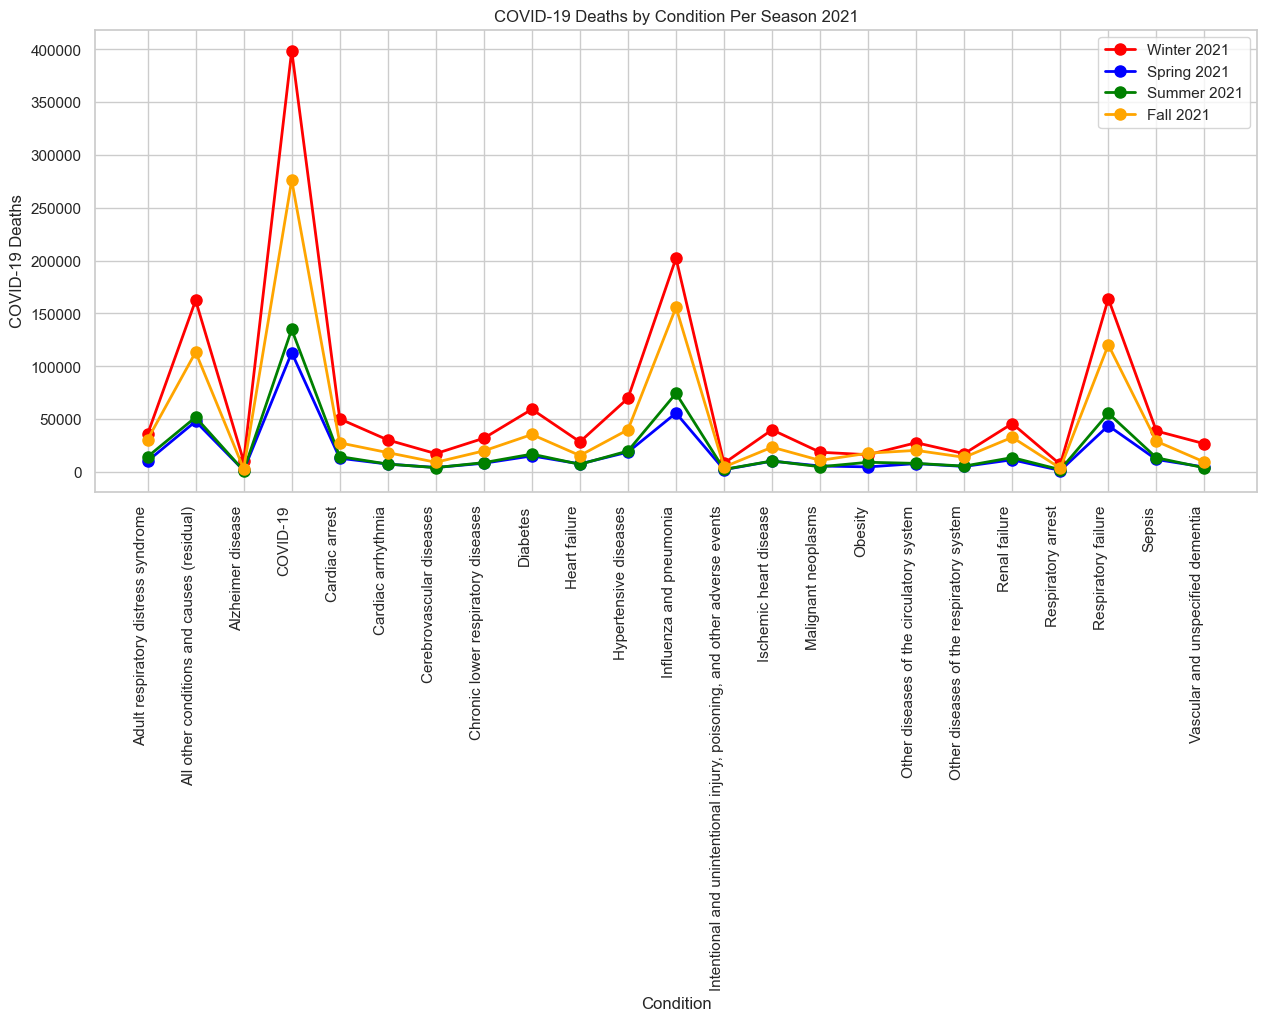

In [121]:

# Create a Line Graph to show the number of COVID-19 deaths by season and condition for 2021
condition2021 = condition_df[condition_df['Year'] == 2021]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition2021[condition2021['Season'] == 'Winter']['Condition']
y1 = condition2021[condition2021['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition2021[condition2021['Season'] == 'Spring']['Condition']
y2 = condition2021[condition2021['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition2021[condition2021['Season'] == 'Summer']['Condition']
y3 = condition2021[condition2021['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition2021[condition2021['Season'] == 'Fall']['Condition']
y4 = condition2021[condition2021['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=90, ha='right')
plt.title('COVID-19 Deaths by Condition Per Season 2021')
plt.xlabel('Condition')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2021', 'Spring 2021', 'Summer 2021', 'Fall 2021'])

# Show the plot
plt.show()


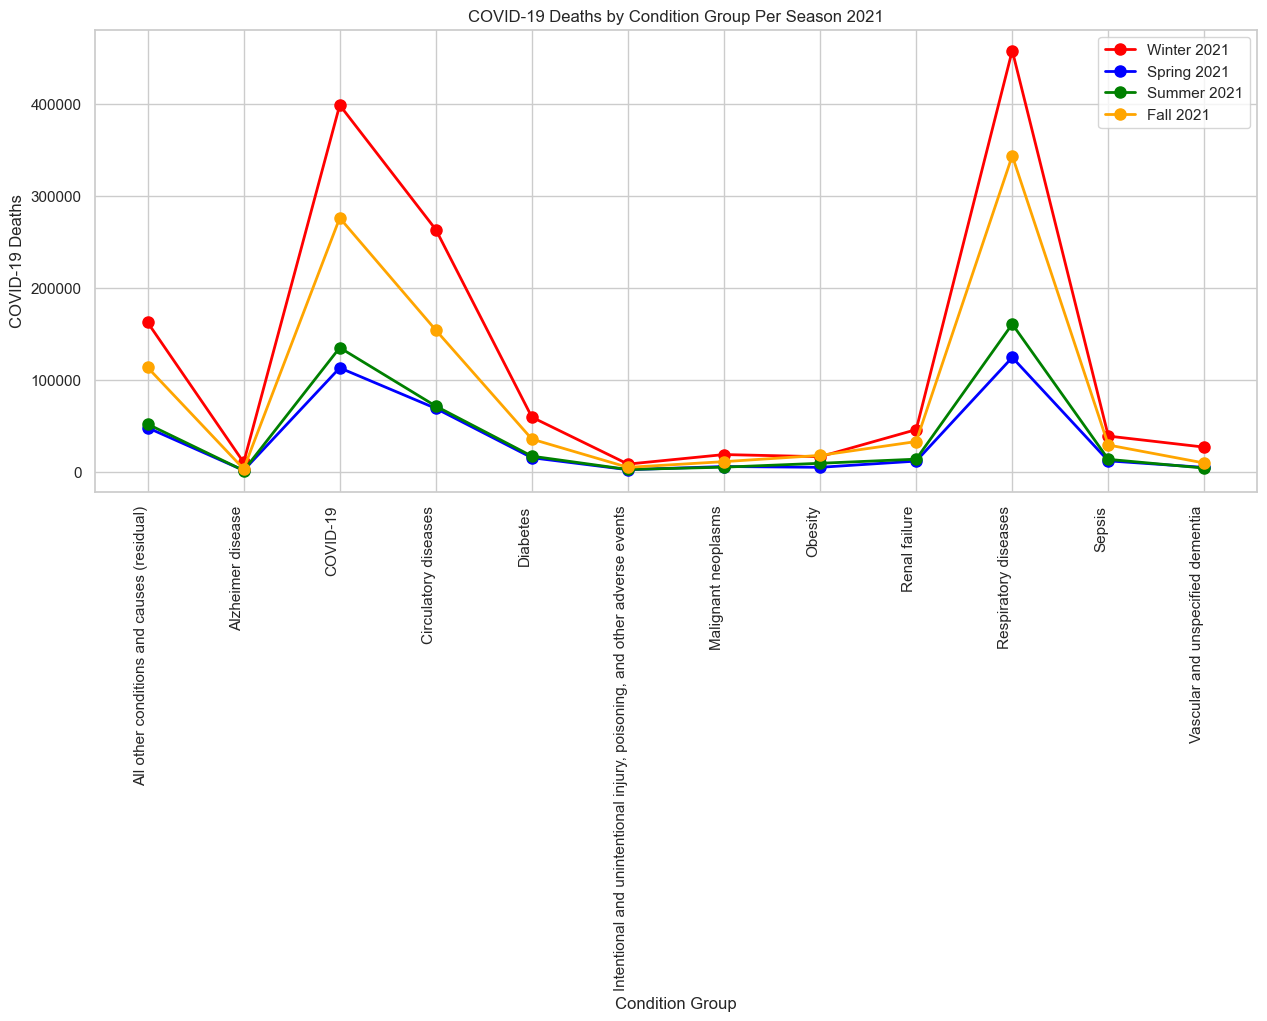

In [122]:
# Create a Line Graph to show the number of COVID-19 deaths by season and condition group for 2021
condition_group2021 = condition_group_df[condition_group_df['Year'] == 2021]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition_group2021[condition_group2021['Season'] == 'Winter']['Condition Group']
y1 = condition_group2021[condition_group2021['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition_group2021[condition_group2021['Season'] == 'Spring']['Condition Group']
y2 = condition_group2021[condition_group2021['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition_group2021[condition_group2021['Season'] == 'Summer']['Condition Group']
y3 = condition_group2021[condition_group2021['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition_group2021[condition_group2021['Season'] == 'Fall']['Condition Group']
y4 = condition_group2021[condition_group2021['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=90, ha='right')
plt.title('COVID-19 Deaths by Condition Group Per Season 2021')
plt.xlabel('Condition Group')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2021', 'Spring 2021', 'Summer 2021', 'Fall 2021'])

# Show the plot
plt.show()

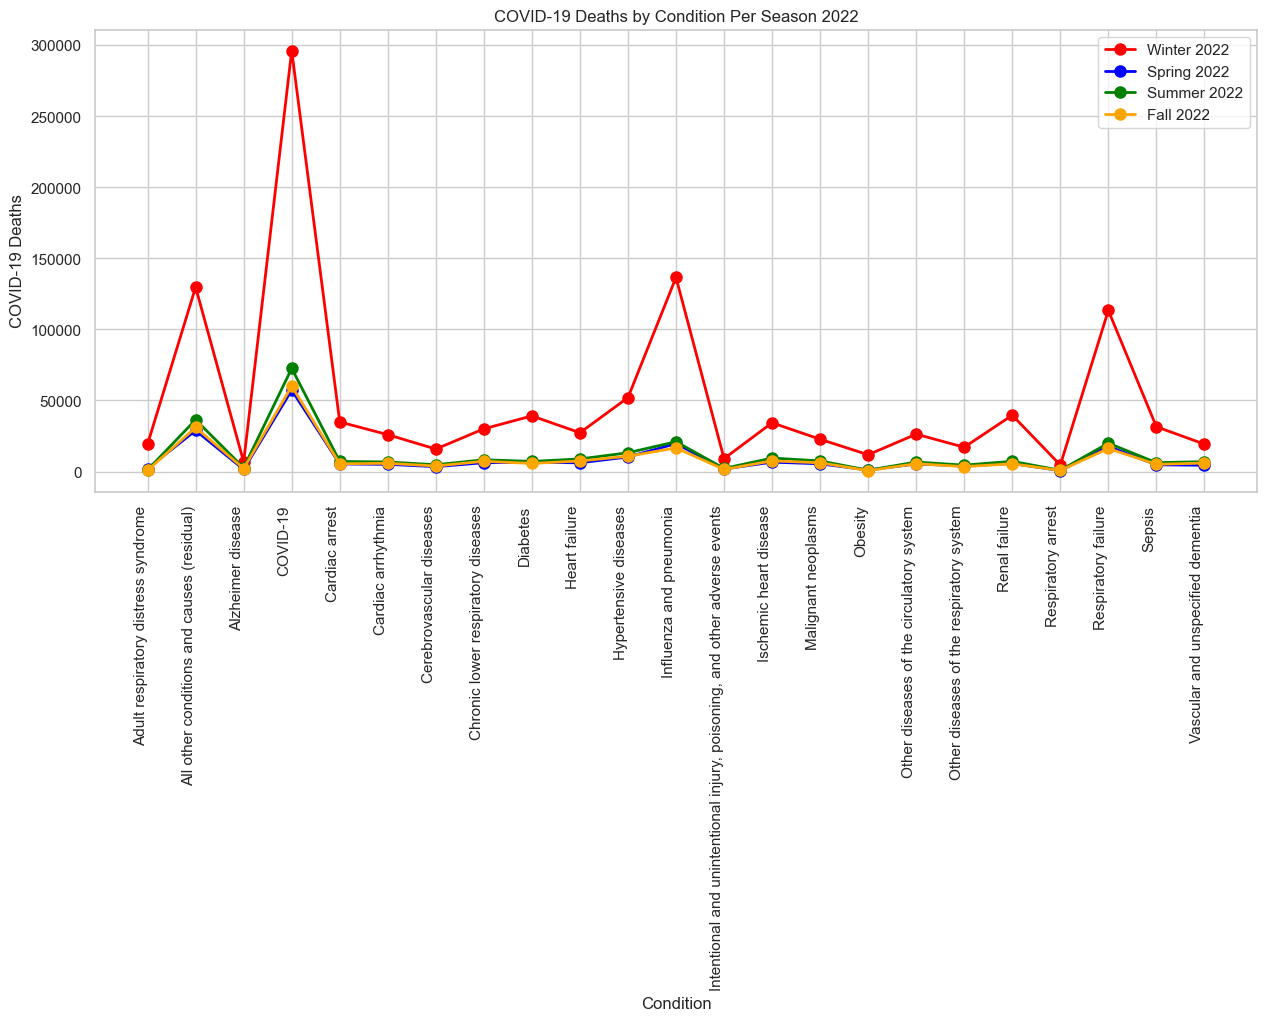

In [123]:
# Create a Line Graph to show the number of COVID-19 deaths by season and condition for 2022
condition2022 = condition_df[condition_df['Year'] == 2022]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition2022[condition2022['Season'] == 'Winter']['Condition']
y1 = condition2022[condition2022['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition2022[condition2022['Season'] == 'Spring']['Condition']
y2 = condition2022[condition2022['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition2022[condition2022['Season'] == 'Summer']['Condition']
y3 = condition2022[condition2022['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition2022[condition2022['Season'] == 'Fall']['Condition']
y4 = condition2022[condition2022['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=90, ha='right')
plt.title('COVID-19 Deaths by Condition Per Season 2022')
plt.xlabel('Condition')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2022', 'Spring 2022', 'Summer 2022', 'Fall 2022'])

# Show the plot
plt.show()

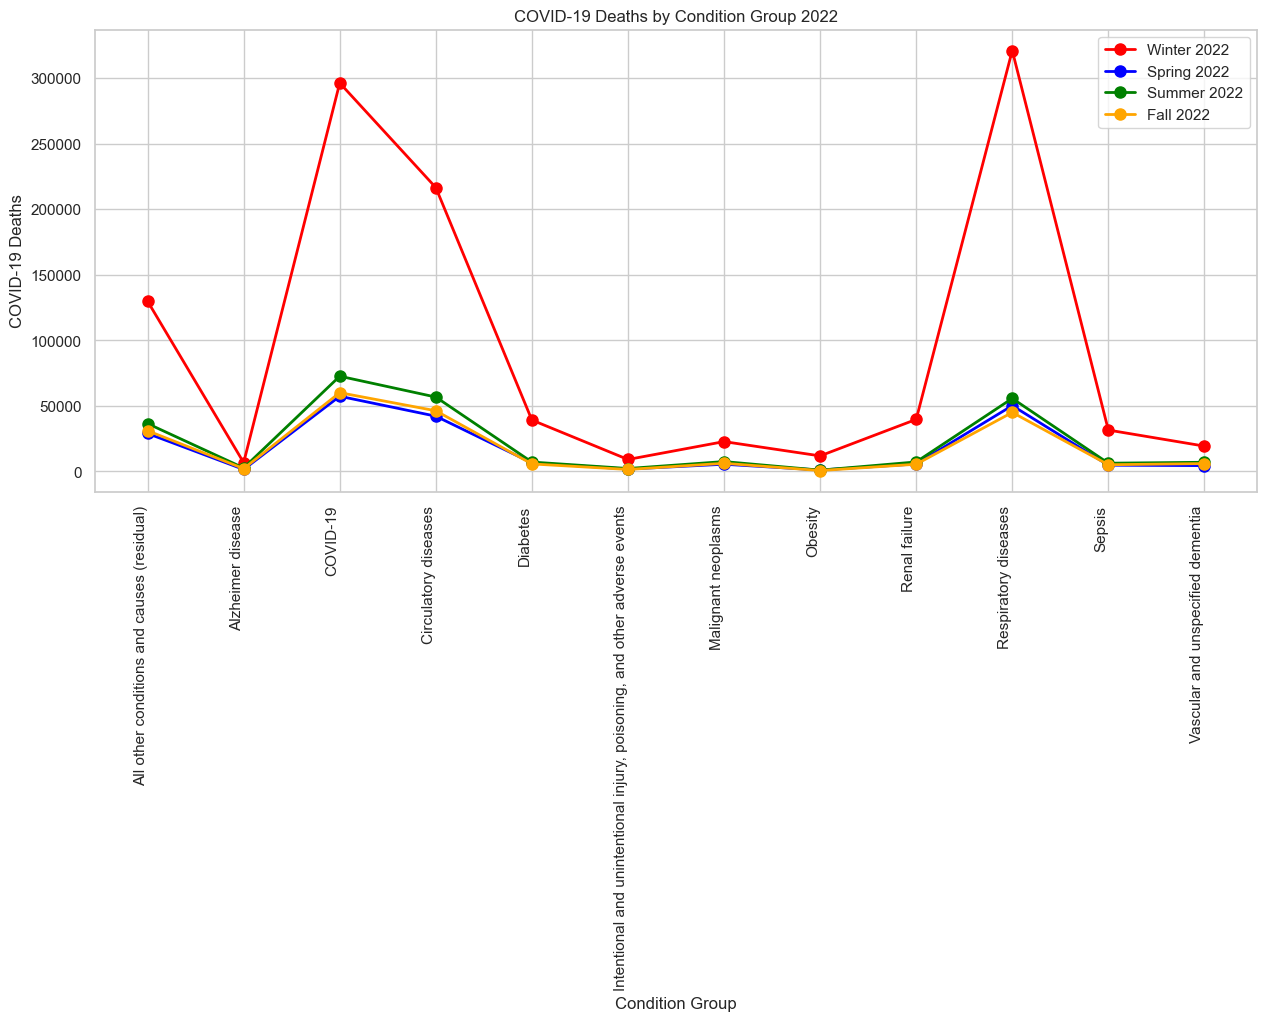

In [124]:
# Create a Line Graph to show the number of COVID-19 deaths by season and condition group for 2022
condition_group2022 = condition_group_df[condition_group_df['Year'] == 2022]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition_group2022[condition_group2022['Season'] == 'Winter']['Condition Group']
y1 = condition_group2022[condition_group2022['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition_group2022[condition_group2022['Season'] == 'Spring']['Condition Group']
y2 = condition_group2022[condition_group2022['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition_group2022[condition_group2022['Season'] == 'Summer']['Condition Group']
y3 = condition_group2022[condition_group2022['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition_group2022[condition_group2022['Season'] == 'Fall']['Condition Group']
y4 = condition_group2022[condition_group2022['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=90, ha='right')
plt.title('COVID-19 Deaths by Condition Group 2022')
plt.xlabel('Condition Group')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2022', 'Spring 2022', 'Summer 2022', 'Fall 2022'])

# Show the plot
plt.show()